In [2]:
%load_ext autoreload
%autoreload 2

import sys
if sys.path[-1] != "..": sys.path.append("..")

from source.qBN.qBNMC import qBayesNet
from source.qBN.qBNRejection import qInference
from source.qBN.qBNRT import qRuntime

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33'
)

backend = service.get_backend("ibm_brisbane")

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33')

# Demo 1: 
### 3 variables, 2 states per variable 

In [64]:
bn1 = gum.fastBN("A->B<-C", 2)
bn1

(pyAgrum.BayesNet<double>@0x632dc0218230) BN{nodes: 3, arcs: 2, domainSize: 8, dim: 6, mem: 96o}

In [65]:
qbn1 = qBayesNet(bn1)
qc1 = qbn1.buildCircuit(add_measure=True)
#qc1.draw(output="mpl", scale=0.5)

In [69]:
ev1 = {"B": 0}
ie1=gum.LazyPropagation(bn1)
ie1.setEvidence(ev1)
ie1.makeInference()
print(f"Evidence: {ev1}")
print(f"Evidence probability: {ie1.evidenceProbability()}")

Evidence: {'B': 0}
Evidence probability: 0.6405078326629379


In [67]:
target_node_bn1 = "A"

In [68]:
qinf1 = qInference(qbn1)
qinf1.setEvidence(ev1)
qinf1.setMaxIter(1000)
qinf1.useFragmentBN(target={target_node_bn1})
qinf1.qbn.bn

(pyAgrum.BayesNet<double>@0x632db70c5590) BN{nodes: 3, arcs: 2, domainSize: 8, dim: 6, mem: 96o}

In [ ]:
#ie1.posterior(target_node_bn1)

In [70]:
qinf1.makeInference()

In [71]:
gnb.sideBySide(qinf1.posterior(target_node_bn1),
               ie1.posterior(target_node_bn1),
               captions=["qInference", "LazyPropagation"])

In [72]:
qrt1 = qRuntime(qinf1, backend)
qrt1.getGateExecutionTime()
print(f"q-Inference log: {qrt1.qinf.log}")
qrt1.rejectionSamplingRuntime()

A gate transpiled circuit depth: 148
A gate execution time: 4.3520000000000003e-05 s
G gate transpiled circuit depth: 176
G gate execution time: 4.54e-05 s
q-Inference log: {'A': 1894, 'G': 1930}


0.17004888

# Demo 2:
### 3 variables, 5 states  per variable

In [53]:
bn2 = gum.fastBN("A->B<-C", 3)
bn2

(pyAgrum.BayesNet<double>@0x632db2b29920) BN{nodes: 3, arcs: 2, domainSize: 27, dim: 22, mem: 264o}

In [54]:
qbn2 = qBayesNet(bn2)
qc2 = qbn2.buildCircuit(add_measure=True)
#qc2.draw(output="mpl", scale=0.5)

In [55]:
ev2 = {"B": 0}
ie2=gum.LazyPropagation(bn2)
ie2.setEvidence(ev2)
ie2.makeInference()
print(f"Evidence: {ev2}")
print(f"Evidence probability: {ie2.evidenceProbability()}")

Evidence: {'B': 0}
Evidence probability: 0.5101632293848157


In [56]:
target_node_bn2 = "A"

In [60]:
qinf2 = qInference(qbn2)
qinf2.setEvidence(ev2)
qinf2.setMaxIter(1000)
qinf2.useFragmentBN(target={target_node_bn2})
qinf2.qbn.bn

(pyAgrum.BayesNet<double>@0x632db57b1480) BN{nodes: 3, arcs: 2, domainSize: 27, dim: 22, mem: 264o}

In [61]:
qinf2.makeInference()

In [62]:
gnb.sideBySide(qinf2.posterior(target_node_bn2),
               ie2.posterior(target_node_bn2),
               captions=["qInference", "LazyPropagation"])

In [63]:
qrt2 = qRuntime(qinf2, backend)
qrt2.getGateExecutionTime()
print(f"q-Inference log: {qrt2.qinf.log}")
qrt2.rejectionSamplingRuntime()

A gate transpiled circuit depth: 17253
A gate execution time: 0.005118360000000001 s
G gate transpiled circuit depth: 17272
G gate execution time: 0.00511884 s
q-Inference log: {'A': 1920, 'G': 3630}


28.408640400000003

# Demo 3: (Section 4.1)
### 4 variables, 2 states  per variable

In [41]:
bn3 = gum.fastBN("IR->SM->SP<-OI", 2)
bn3.cpt("IR")[:] = [0.75, 0.25]
bn3.cpt("SM")[:] = [[0.3, 0.7], [0.8, 0.2]]
bn3.cpt("OI")[:] = [0.6,0.4]
bn3.cpt("SP")[:] = [[[0.9, 0.1], [0.5, 0.5]], [[0.4, 0.6], [0.2, 0.8]]]
bn3

(pyAgrum.BayesNet<double>@0x632dae1906a0) BN{nodes: 4, arcs: 3, domainSize: 16, dim: 8, mem: 128o}

In [42]:
qbn3 = qBayesNet(bn3)
qc3 = qbn3.buildCircuit(add_measure=True)
#qc3.draw(output="mpl", scale=0.5)

In [43]:
target_node_bn3 = "OI"

In [44]:
ev3 = {"SP": 1}
ie3=gum.LazyPropagation(bn3)
ie3.setEvidence(ev3)
ie3.makeInference()
print(f"Evidence: {ev3}")
print(f"Evidence probability: {ie3.evidenceProbability()}")
#ie3.posterior(target_node_bn3)

Evidence: {'SP': 1}
Evidence probability: 0.48400000000000004


In [45]:
qinf3 = qInference(qbn3)
qinf3.setEvidence(ev3)
qinf3.setMaxIter(1000)
qinf3.useFragmentBN(target={target_node_bn3})
qinf3.qbn.bn

(pyAgrum.BayesNet<double>@0x632db44b6220) BN{nodes: 4, arcs: 3, domainSize: 16, dim: 8, mem: 128o}

In [47]:
qinf3.makeInference()

In [46]:
gnb.sideBySide(qinf3.posterior(target_node_bn3),
               ie3.posterior(target_node_bn3),
               captions=["qInference", "LazyPropagation"])

In [47]:
qrt3 = qRuntime(qinf3, backend)
qrt3.getGateExecutionTime()
print(f"q-Inference log: {qrt3.qinf.log}")
qrt3.rejectionSamplingRuntime()

A gate transpiled circuit depth: 953
A gate execution time: 0.00029383999999999996 s
G gate transpiled circuit depth: 935
G gate execution time: 0.0002693 s
q-Inference log: {'A': 2014, 'G': 6394}


2.31369796

# Demo 4: (Section 4.2)
### 10 variables, 2 states  per variable

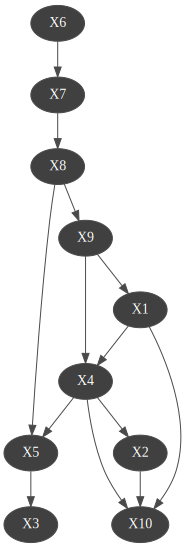

In [21]:
bn4 = gum.fastBN("X6->X7->X8->X5->X3; X8->X9->X1->X10; X9->X4<-X1; X5<-X4->X10; X4->X2->X10", 2)
bn4.cpt("X6")[:] = [0.98, 0.02]
bn4.cpt("X7")[:] = [[0.988, 0.012], [0.429, 0.571]]
bn4.cpt("X8")[:] = [[0.006,0.994], [0.875, 0.125]]
bn4.cpt("X9")[:] = [[0, 1], [0.982, 0.018]]
bn4.cpt("X1")[:] = [[0.448, 0.552], [0.067, 0.933]]
bn4.cpt("X4")[:] = [[[0.151, 0.849], [0.874, 0.126]], [[1, 0], [1, 0]]]
bn4.cpt("X2")[:] = [[0.76, 0.24], [1, 0]]
bn4.cpt("X5")[:] = [[[0, 1], [0, 1]], [[0.723, 0.277], [0.311, 0.689]]]
bn4.cpt("X3")[:] = [[1, 0], [0.949, 0.051]]
bn4.cpt("X10")[:] = [[[[0.684, 0.316], [0, 1]], [[0, 1], [0.474, 0.526]]], [[[1, 0], [0, 1]], [[0.481, 0.519], [1, 0]]]]

gnb.showBN(bn4, size=10)

In [28]:
qbn4 = qBayesNet(bn4)
qc4 = qbn4.buildCircuit(add_measure=True)
#qc4.draw(output="mpl", scale=0.5)

In [24]:
ev4 = {"X9": 1}
ie4=gum.LazyPropagation(bn4)
ie4.setEvidence(ev4)
ie4.makeInference()
print(f"Evidence: {ev4}")
print(f"Evidence probability: {ie4.evidenceProbability()}")

Evidence: {'X9': 1}
Evidence probability: 0.04367283844000001


In [39]:
target_node_bn4 = "X6"

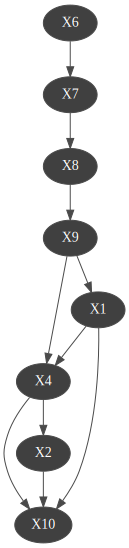

In [25]:
qinf4 = qInference(qbn4)
qinf4.setEvidence(ev4)
qinf4.setMaxIter(1000)
qinf4.useFragmentBN(target={target_node_bn4})
gnb.showBN(qinf4.qbn.bn, size=10)

In [26]:
qinf4.makeInference()

In [40]:
gnb.sideBySide(qinf4.posterior(target_node_bn4),
               ie4.posterior(target_node_bn4),
               captions=["qInference", "LazyPropagation"])

In [62]:
qrt4 = qRuntime(qinf4, backend)
qrt4.getGateExecutionTime()
print(f"q-Inference log: {qrt4.qinf.log}")
qrt4.rejectionSamplingRuntime()

A gate transpiled circuit depth: 264036
A gate execution time: 0.08419066 s


KeyboardInterrupt: 

# Demo 5:
### Demo 4 with nodes X2, X4, X1, X10

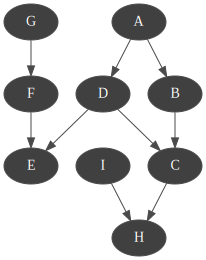

In [4]:
bn5 = gum.fastBN("A->B->C->H;I->H;A->D->C;D->E;G->F->E", 2)

gnb.showBN(bn5, size=10)

In [6]:
qbn5 = qBayesNet(bn5)
qc5 = qbn5.buildCircuit(add_measure=True)
#qc5.draw(output="mpl", scale=0.5)

In [7]:
ev5 = {"H": 0, "A":1}
ie5=gum.LazyPropagation(bn5)
ie5.setEvidence(ev5)
ie5.makeInference()
print(f"Evidence: {ev5}")
print(f"Evidence probability: {ie5.evidenceProbability()}")

Evidence: {'H': 0, 'A': 1}
Evidence probability: 0.33430046969155575


In [18]:
target_node_bn5 = "D"

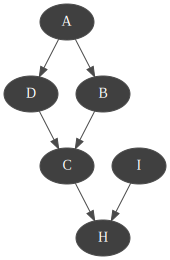

In [9]:
qinf5 = qInference(qbn5)
qinf5.setEvidence(ev5)
qinf5.setMaxIter(5000)
qinf5.useFragmentBN(target={target_node_bn5})
gnb.showBN(qinf5.qbn.bn, size=10)

In [10]:
qinf5.makeInference()

In [19]:
gnb.sideBySide(qinf5.posterior(target_node_bn5),
               ie5.posterior(target_node_bn5),
               captions=["qInference", "LazyPropagation"])

In [20]:
qrt5 = qRuntime(qinf5, backend)
qrt5.getGateExecutionTime()
print(f"q-Inference log: {qrt5.qinf.log}")
qrt5.rejectionSamplingRuntime()

A gate transpiled circuit depth: 17226
A gate execution time: 0.00511116 s
G gate transpiled circuit depth: 17657
G gate execution time: 0.00525096 s
q-Inference log: {'A': 5062, 'G': 5164}


52.98864936